In [9]:
import os
import sys
#dir_path = os.path.dirname(os.path.realpath(__file__))
dir_path = "/Users/neda/HiCPlus_pytorch/src"
model_path = dir_path + "/models"
utils_path = dir_path + "/utils"
sys.path.insert(0, model_path)
sys.path.insert(0, utils_path)
import model
import utils

import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from torch.utils import data
import torch
import torch.optim as optim
from torch.autograd import Variable
from time import gmtime, strftime
import torch.nn as nn
from scipy.stats.stats import pearsonr
import argparse
import cooler


args = {"low_res_cool_path": "/Users/neda/prostate-samples/PCa13266.multi-res.cool"
       , "high_res_cool_path": "/Users/neda/prostate-samples/HighRes-PCa13266.multi-res.cool"
       , "model_path": "/Users/neda/HiCPlus_pytorch/src/learned-networks"
       , "resolution": "10000"
       , "model_name": "chr1-17-PCa13266(up-wo-min)"
       , "chrN_min": "1"
       , "chrN_max": "17"
       , "frames_data_path": "/Users/neda/prostate-samples/divided-data"
       , "sample_name": "PCa13266"}

low_res_cool = cooler.Cooler(args['low_res_cool_path'] + '::/resolutions/' + str(args['resolution']))
high_res_cool = cooler.Cooler(args['high_res_cool_path'] + '::/resolutions/' + str(args['resolution']))

down_sample_ratio = 5
use_gpu = 0
epochs = 10
HiC_max_value = 100
batch_size = 256
if os.path.exists(args['frames_data_path'] + "/" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + ".npy"):
    high_resolution_samples = np.load(args['frames_data_path'] + "/" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + ".npy").astype(np.float32)
    low_resolution_samples = np.load(args['frames_data_path'] + "/down-" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + ".npy").astype(np.float32)
    indices = np.load(args['frames_data_path'] + "/" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + "-index.npy")
else:
    low_resolution_samples = []
    high_resolution_samples = []
    indices = []
    for i in range(int(args['chrN_min']), int(args['chrN_max']) + 1):
        low_chr_mat = low_res_cool.matrix(balance = False).fetch("chr" + str(i)).astype(float)
        high_chr_mat = high_res_cool.matrix(balance = False).fetch("chr" + str(i)).astype(float)
        low_chr_mat[np.isnan(low_chr_mat)] = 0
        high_chr_mat[np.isnan(high_chr_mat)] = 0
        chr_frames, chr_indices = utils.divide2(low_chr_mat,i)
        low_resolution_samples.extend(chr_frames)
        chr_frames, chr_indices = utils.divide2(high_chr_mat,i)
        high_resolution_samples.extend(chr_frames)
        indices.extend(chr_indices)
    low_resolution_samples = np.stack(low_resolution_samples, axis = 0)
    high_resolution_samples = np.stack(high_resolution_samples, axis = 0)
    indices = np.stack(indices, axis = 0)
    np.save(args['frames_data_path'] + "/" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + ".npy", high_resolution_samples)
    np.save(args['frames_data_path'] + "/down-" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + ".npy", low_resolution_samples)
    np.save(args['frames_data_path'] + "/" + args['sample_name'] + "-chr" + args['chrN_min'] + "-" + args['chrN_max'] + "-index.npy", indices)

[[10  9  3  1  2  0  6  0  0  2]
 [ 9 14  4 10  4  2  4  0  4  6]
 [ 3  4  6  2  6  4  0  0  2  1]
 [ 1 10  2 12 12  4  3  1  1  2]
 [ 2  4  6 12 22 12 10  1  1  1]
 [ 0  2  4  4 12 10  8  2  2  2]
 [ 6  4  0  3 10  8 10  6  1  6]
 [ 0  0  0  1  1  2  6  6  9  5]
 [ 0  4  2  1  1  2  1  9  7  9]
 [ 2  6  1  2  1  2  6  5  9  9]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
------- 2843 0 3.181209135056031 2019-07-22 18:53:19
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]
------- 2843 1 3.12792918519008 2019-07-22 18:53:41
[[3 3 2 1 2 2 2 1 1 1]
 [3 3 3 2 2 2 1 2 1 2]
 [2 3 4 3 2 1 1 2 2 2]
 [1 2 3 3 3 2 2 1 2 2]
 [2 2 2 3 

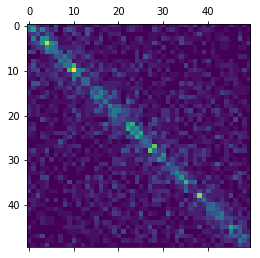

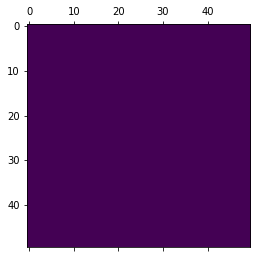

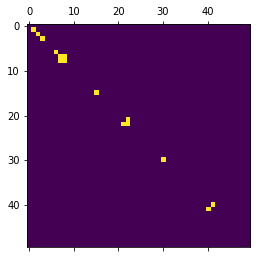

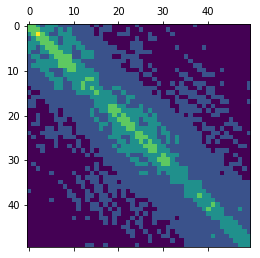

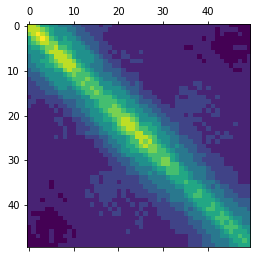

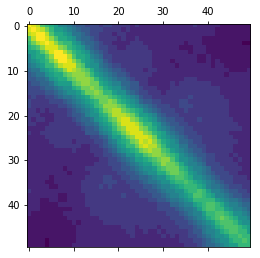

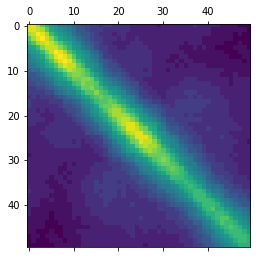

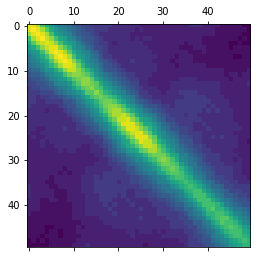

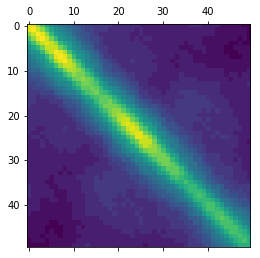

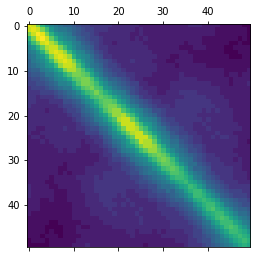

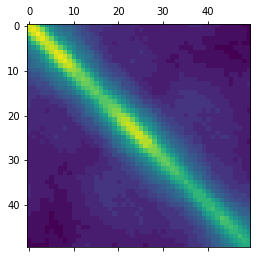

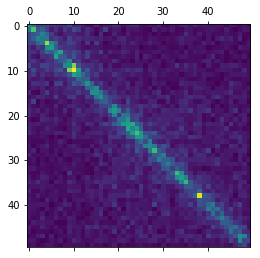

In [10]:
low_resolution_samples = np.expand_dims(low_resolution_samples, axis=1)
high_resolution_samples = np.expand_dims(high_resolution_samples, axis=1)
#low_resolution_samples = np.minimum(HiC_max_value, low_resolution_samples)
#high_resolution_samples = np.minimum(HiC_max_value, high_resolution_samples)
sample_size = low_resolution_samples.shape[-1]
lb = int(model.half_padding)
ub = int(sample_size - model.half_padding)
high_resolution_samples = high_resolution_samples[:,:,lb:ub,lb:ub]
lowres_loader = torch.utils.data.DataLoader(torch.from_numpy(low_resolution_samples), batch_size=batch_size, shuffle=False)
hires_loader = torch.utils.data.DataLoader(torch.from_numpy(high_resolution_samples), batch_size=batch_size, shuffle=False)

#low_chr18_mat = low_res_cool.matrix(balance = False).fetch("chr18").astype(float)
#low_chr18_mat[np.isnan(low_chr18_mat)] = 0
low_chr18_mat = np.load("/Users/neda/prostate-samples/PCa13266-down/chr18.txt_npy_form_tmp.npy")
chr18_frames, chr18_indices = utils.divide2(low_chr18_mat,18)
chr18_frames = np.stack(chr18_frames, axis = 0)
chr18_frames = np.expand_dims(chr18_frames, axis = 1)
chr18_indices = np.stack(chr18_indices, axis = 0)
#enhanced_chr18_mat = low_res_cool.matrix(balance = False).fetch("chr18").astype(float)
#enhanced_chr18_mat[np.isnan(enhanced_chr18_mat)] = 0
enhanced_chr18_mat = np.load("/Users/neda/prostate-samples/PCa13266-down/chr18.txt_npy_form_tmp.npy")
high_chr18_mat = high_res_cool.matrix(balance = False).fetch("chr18").astype(float)
high_chr18_mat[np.isnan(high_chr18_mat)] = 0
l = 2200
u = 2250
plt.matshow(low_chr18_mat[l:u,l:u])
print(low_chr18_mat[l:l+10,l:l+10])
Net = model.Net(40, 28)
if use_gpu:
    Net = Net.cuda()

optimizer = optim.SGD(Net.parameters(), lr = 0.00001)
_loss = nn.MSELoss()
Net.train()

running_loss = 0.0
losslist = []


# write the log file to record the training process
log = open('HindIII_train.txt', 'w')
for epoch in range(0, epochs):
    for i, (v1, v2) in enumerate(zip(lowres_loader, hires_loader)):
        if (i == len(lowres_loader) - 1):
            continue
        _lowRes = Variable(v1)
        _highRes = Variable(v2)
        if use_gpu:
            _lowRes = _lowRes.cuda()
            _highRes = _highRes.cuda()
        optimizer.zero_grad()
        y_prediction = Net(_lowRes)
        loss = _loss(y_prediction, _highRes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    chr18_prediction = Net(Variable(torch.from_numpy(chr18_frames).float()))
    chr18_prediction = chr18_prediction.data.cpu().numpy()
    chr18_prediction = np.reshape(chr18_prediction, (chr18_prediction.shape[0], chr18_prediction.shape[2], chr18_prediction.shape[3]))
    for i in range(chr18_indices.shape[0]):
        x_pos = chr18_indices[i,1]
        y_pos = chr18_indices[i,2]
        enhanced_chr18_mat[x_pos+6:x_pos+34,y_pos+6:y_pos+34] = chr18_prediction[i,:,:]

    iu = np.triu_indices(enhanced_chr18_mat.shape[0],1)
    il = (iu[1],iu[0])
    enhanced_chr18_mat[il]=enhanced_chr18_mat[iu]
    print(enhanced_chr18_mat[l:l+10,l:l+10])
    plt.matshow(enhanced_chr18_mat[l:u,l:u])
    print ('-------', i, epoch, running_loss/i, strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    losslist.append(running_loss/i)
    log.write(str(epoch) + ', ' + str(running_loss/i,) + '\n')
    running_loss = 0.0
print(high_chr18_mat[l:l+10,l:l+10])
plt.matshow(high_chr18_mat[l:u,l:u])


[[15.  6.  3.  6.  6.  2.  1.  2.  3.  3.]
 [ 6. 18.  6.  6.  2.  1.  0.  1.  5.  2.]
 [ 3.  6.  6.  7.  5.  1.  1.  1.  3.  3.]
 [ 6.  6.  7. 10.  6.  4.  6.  3.  1.  2.]
 [ 6.  2.  5.  6. 19. 10.  8.  0.  1.  2.]
 [ 2.  1.  1.  4. 10. 11.  5.  3.  2.  3.]
 [ 1.  0.  1.  6.  8.  5.  6. 15.  1.  4.]
 [ 2.  1.  1.  3.  0.  3. 15.  7.  7.  3.]
 [ 3.  5.  3.  1.  1.  2.  1.  7.  9. 11.]
 [ 3.  2.  3.  2.  2.  3.  4.  3. 11.  7.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
------- 956 0 8.470631242125728 2019-07-16 19:37:59
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0

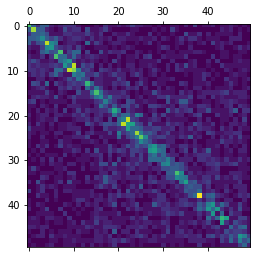

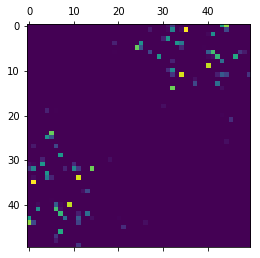

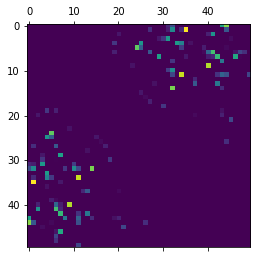

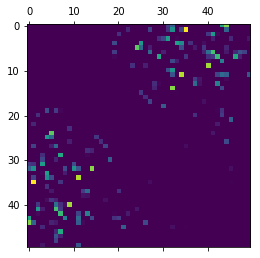

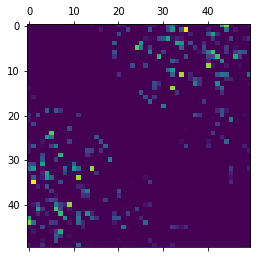

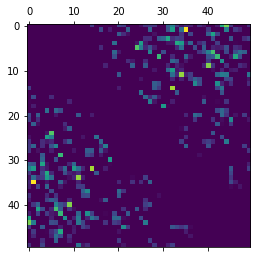

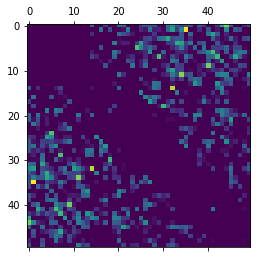

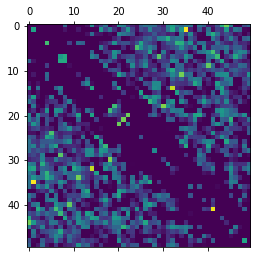

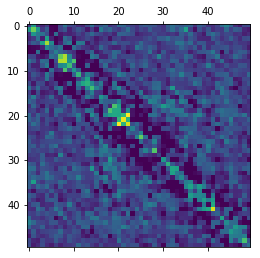

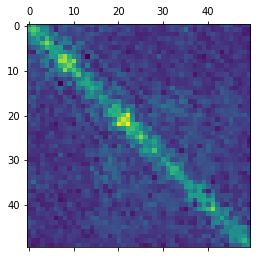

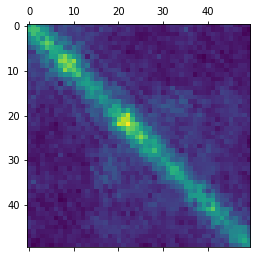

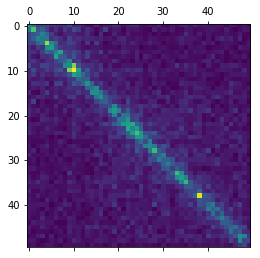

In [35]:
low_resolution_samples = np.expand_dims(low_resolution_samples, axis=1)
high_resolution_samples = np.expand_dims(high_resolution_samples, axis=1)
#low_resolution_samples = np.minimum(HiC_max_value, low_resolution_samples)
#high_resolution_samples = np.minimum(HiC_max_value, high_resolution_samples)
sample_size = low_resolution_samples.shape[-1]
lb = int(model2.half_padding)
ub = int(sample_size - model2.half_padding)
high_resolution_samples = high_resolution_samples[:,:,lb:ub,lb:ub]
lowres_loader = torch.utils.data.DataLoader(torch.from_numpy(low_resolution_samples), batch_size=batch_size, shuffle=False)
hires_loader = torch.utils.data.DataLoader(torch.from_numpy(high_resolution_samples), batch_size=batch_size, shuffle=False)

low_chr18_mat = low_res_cool.matrix(balance = False).fetch("chr18").astype(float)
low_chr18_mat[np.isnan(low_chr18_mat)] = 0
chr18_frames, chr18_indices = utils.divide2(low_chr18_mat,18)
chr18_frames = np.stack(chr18_frames, axis = 0)
chr18_frames = np.expand_dims(chr18_frames, axis = 1)
chr18_indices = np.stack(chr18_indices, axis = 0)
enhanced_chr18_mat = low_res_cool.matrix(balance = False).fetch("chr18").astype(float)
enhanced_chr18_mat[np.isnan(enhanced_chr18_mat)] = 0
high_chr18_mat = high_res_cool.matrix(balance = False).fetch("chr18").astype(float)
high_chr18_mat[np.isnan(high_chr18_mat)] = 0
l = 2200
u = 2250
plt.matshow(low_chr18_mat[l:u,l:u])
print(low_chr18_mat[l:l+10,l:l+10])
Net = model2.Net(40, 34)
if use_gpu:
    Net = Net.cuda()

optimizer = optim.SGD(Net.parameters(), lr = 0.00001)
_loss = nn.MSELoss()
Net.train()

running_loss = 0.0
losslist = []


# write the log file to record the training process
log = open('HindIII_train.txt', 'w')
for epoch in range(0, epochs):
    for i, (v1, v2) in enumerate(zip(lowres_loader, hires_loader)):
        if (i == len(lowres_loader) - 1):
            continue
        _lowRes = Variable(v1)
        _highRes = Variable(v2)
        if use_gpu:
            _lowRes = _lowRes.cuda()
            _highRes = _highRes.cuda()
        optimizer.zero_grad()
        y_prediction = Net(_lowRes)
        loss = _loss(y_prediction, _highRes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    chr18_prediction = Net(Variable(torch.from_numpy(chr18_frames).float()))
    chr18_prediction = chr18_prediction.data.cpu().numpy()
    chr18_prediction = np.reshape(chr18_prediction, (chr18_prediction.shape[0], chr18_prediction.shape[2], chr18_prediction.shape[3]))
    for i in range(chr18_indices.shape[0]):
        x_pos = chr18_indices[i,1]
        y_pos = chr18_indices[i,2]
        enhanced_chr18_mat[x_pos+3:x_pos+37,y_pos+3:y_pos+37] = chr18_prediction[i,:,:]

    iu = np.triu_indices(enhanced_chr18_mat.shape[0],1)
    il = (iu[1],iu[0])
    enhanced_chr18_mat[il]=enhanced_chr18_mat[iu]
    print(enhanced_chr18_mat[l:l+10,l:l+10])
    plt.matshow(enhanced_chr18_mat[l:u,l:u])
    print ('-------', i, epoch, running_loss/i, strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    losslist.append(running_loss/i)
    log.write(str(epoch) + ', ' + str(running_loss/i,) + '\n')
    running_loss = 0.0
print(high_chr18_mat[l:l+10,l:l+10])
plt.matshow(high_chr18_mat[l:u,l:u])



In [1]:
import numpy as np
high_frames = np.load("/Users/neda/prostate-samples/divided-data/PCa13266-chr1-17.npy")

In [4]:
low_frames = np.load("/Users/neda/prostate-samples/divided-data/RandDown-PCa13266-chr1-17.npy")

In [6]:
print(high_frames.shape, low_frames.shape)
print(high_frames[20000,])
print(low_frames[20000,])

(30777, 40, 40) (30777, 40, 40)
[[ 4.  2.  0. ...  4. 10.  1.]
 [ 1.  6.  1. ...  0.  3.  2.]
 [ 8.  2.  2. ...  2.  3.  2.]
 ...
 [ 9.  7.  6. ...  7.  2.  4.]
 [ 4.  9.  1. ...  2.  1.  5.]
 [ 5.  6.  2. ...  0.  2.  5.]]
[[0 0 0 ... 2 3 0]
 [0 0 0 ... 0 1 0]
 [2 1 0 ... 0 0 0]
 ...
 [0 1 4 ... 0 1 0]
 [1 4 0 ... 1 0 1]
 [0 3 2 ... 0 1 1]]


In [12]:
indices = np.load("/Users/neda/prostate-samples/divided-data/PCa13266-chr1-17-index.npy")

In [16]:
enhanced_chr18_mat[100:110,100:110]

array([[1.77884781, 2.29668212, 2.03878975, 1.66159809, 1.76387393,
        1.44344223, 1.08700299, 1.29740632, 1.10963809, 0.89578658],
       [2.29668212, 1.86771476, 2.01646757, 1.8970319 , 1.63128769,
        1.42803478, 1.52211523, 1.255144  , 0.91187537, 1.09188104],
       [2.03878975, 2.01646757, 1.86664808, 1.80014038, 1.72674263,
        1.77405846, 1.35306847, 1.19596016, 1.32128155, 1.15629494],
       [1.66159809, 1.8970319 , 1.80014038, 1.80752289, 1.62103295,
        1.51955235, 1.64856184, 1.67221332, 1.27753222, 1.31106293],
       [1.76387393, 1.63128769, 1.72674263, 1.62103295, 1.71652079,
        1.93417764, 1.60739076, 1.25997472, 1.412678  , 1.55303442],
       [1.44344223, 1.42803478, 1.77405846, 1.51955235, 1.93417764,
        1.60917282, 1.45392132, 1.54516053, 1.82008827, 1.35850704],
       [1.08700299, 1.52211523, 1.35306847, 1.64856184, 1.60739076,
        1.45392132, 1.68706763, 1.55905461, 1.74117756, 1.77148688],
       [1.29740632, 1.255144  , 1.1959601

In [25]:
low_resolution_samples.shape

(30777, 1, 40, 40)